### Loading and preprocessing historical futures data

I need to load and clean up data so I can do some sick arbs

Since we're doing metal spot/future arbitrage, we need futures and spot gold data.

We'll get the spot gold data from Tiingo, and the gold futures data from DataBento.

Let's start with the futures data since that is the hardest to work with.

In [1]:
import pandas as pd

df = pd.read_csv('raw_futures_data.csv')

print(df.head(10))


                          ts_recv                        ts_event  rtype  \
0  2015-06-11T00:01:00.000000000Z  2015-06-10T20:28:31.550000000Z    196   
1  2015-06-11T00:01:00.000000000Z                             NaN    196   
2  2015-06-11T00:01:00.000000000Z                             NaN    196   
3  2015-06-11T00:01:00.000000000Z                             NaN    196   
4  2015-06-11T00:01:00.000000000Z  2015-06-11T00:00:56.211000000Z    196   
5  2015-06-11T00:01:00.000000000Z  2015-06-10T20:28:31.550000000Z    196   
6  2015-06-11T00:01:00.000000000Z  2015-06-10T17:38:34.655000000Z    196   
7  2015-06-11T00:01:00.000000000Z  2015-06-10T23:07:49.487000000Z    196   
8  2015-06-11T00:01:00.000000000Z  2015-06-10T16:51:39.847000000Z    196   
9  2015-06-11T00:01:00.000000000Z  2015-06-10T23:07:49.487000000Z    196   

   publisher_id  instrument_id side   price  size  flags  sequence  bid_px_00  \
0             1         140396    N  1198.3    14    138   7595963     1196.0   
1

Wow!!! that's messy. It seems that we have a lot of rich data, but it needs to be cleaned. There's obviously not a quote given every minute, because there is only a data point collected when a trade occurs.

Let's process it into a cleaner format, ignoring multi-expiry futures.

In [3]:
#functions to clean and resample futures data

import numpy as np

def is_valid_contract(symbol: str) -> bool:
    """Return True if symbol looks like a single futures contract (e.g. GCZ2), not a spread like GCZ2-GCG3."""
    return '-' not in symbol and symbol.startswith("GC") and len(symbol) in (4, 5)

def load_and_resample_futures_data(csv_path: str, resample_freq='1min'):
    """
    Load gold futures data, filter out spreads, and resample prices to specified frequency.
    
    Parameters:
        csv_path (str): Path to CSV file
        resample_freq (str): e.g. '1min', '5min'

    Returns:
        pd.DataFrame: Resampled DataFrame with datetime index and one column per contract
    """
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Use ts_event as the real timestamp if available, else ts_recv
    df['timestamp'] = pd.to_datetime(df['ts_event'].fillna(df['ts_recv']))
    df = df.set_index('timestamp')

    # Filter for only valid individual futures contracts
    df = df[df['symbol'].apply(is_valid_contract)]

    # Keep only rows with valid price values
    df = df[pd.to_numeric(df['price'], errors='coerce').notnull()]
    df['price'] = df['price'].astype(float)

    # Pivot to create a contract × time matrix
    futures_dict = {}
    for symbol, group in df.groupby('symbol'):
        resampled = group['price'].resample(resample_freq).last().dropna()
        futures_dict[symbol] = resampled

    # Combine into a single DataFrame
    futures_df = pd.DataFrame(futures_dict)
    futures_df = futures_df.sort_index()

    return futures_df

#path = '../../../data/futures/GOLD/glbx-mdp3-20150611.bbo-1m.csv'
path = "raw_futures_data.csv"


df = load_and_resample_futures_data(path)

for row in df.iterrows():
    print(row)

    

(Timestamp('2015-06-10 10:45:00+0000', tz='UTC'), GCG6       NaN
GCG7       NaN
GCJ6       NaN
GCM5       NaN
GCM6       NaN
GCM7       NaN
GCM8    1214.1
GCN5       NaN
GCQ5       NaN
GCQ6       NaN
GCV5       NaN
GCZ5       NaN
GCZ6       NaN
Name: 2015-06-10 10:45:00+00:00, dtype: float64)
(Timestamp('2015-06-10 14:14:00+0000', tz='UTC'), GCG6       NaN
GCG7    1200.5
GCJ6       NaN
GCM5       NaN
GCM6       NaN
GCM7       NaN
GCM8       NaN
GCN5       NaN
GCQ5       NaN
GCQ6       NaN
GCV5       NaN
GCZ5       NaN
GCZ6       NaN
Name: 2015-06-10 14:14:00+00:00, dtype: float64)
(Timestamp('2015-06-10 17:22:00+0000', tz='UTC'), GCG6       NaN
GCG7       NaN
GCJ6       NaN
GCM5       NaN
GCM6       NaN
GCM7    1205.6
GCM8       NaN
GCN5       NaN
GCQ5       NaN
GCQ6       NaN
GCV5       NaN
GCZ5       NaN
GCZ6       NaN
Name: 2015-06-10 17:22:00+00:00, dtype: float64)
(Timestamp('2015-06-10 19:23:00+0000', tz='UTC'), GCG6    1189.2
GCG7       NaN
GCJ6       NaN
GCM5       NaN
GCM6    

Here's one day of 1m BBO futures data.

Since my arbitrage strategy trades the spread between the current spot gold price and a gold futures contract, and I have a bunch of contracts of different settlement dates to choose from, I need to pick a settlement date for each timestamp.

Apparently it's most effective to use the front month, or the next contract to expire after each timestamp. It's the most liquid and I believe the most likely to hold true to theoretical pricing, therefore I will try that contract first.


Given a timestamp, it's not exactly the easiest thing to reverse engineer the next expiring contract using just the date, because COMEX has a "third business last business day" settlement policy, and depending on the day of the month, the current month's contract could or could not have already expired.

I suspect that the best thing to do is just to find the most liquid contract of the day and pick that one. This should be a lot easier and likely will mean better spread reconvergence(?)

Let's plot a single day's contract number of trades as a bar chart to find the most liquid contract.

dict_keys(['GCG6', 'GCG7', 'GCJ6', 'GCM5', 'GCM6', 'GCM7', 'GCM8', 'GCN5', 'GCQ5', 'GCQ6', 'GCV5', 'GCZ5', 'GCZ6']) dict_values([37, 1, 12, 31, 12, 1, 1, 127, 1314, 10, 129, 186, 18])


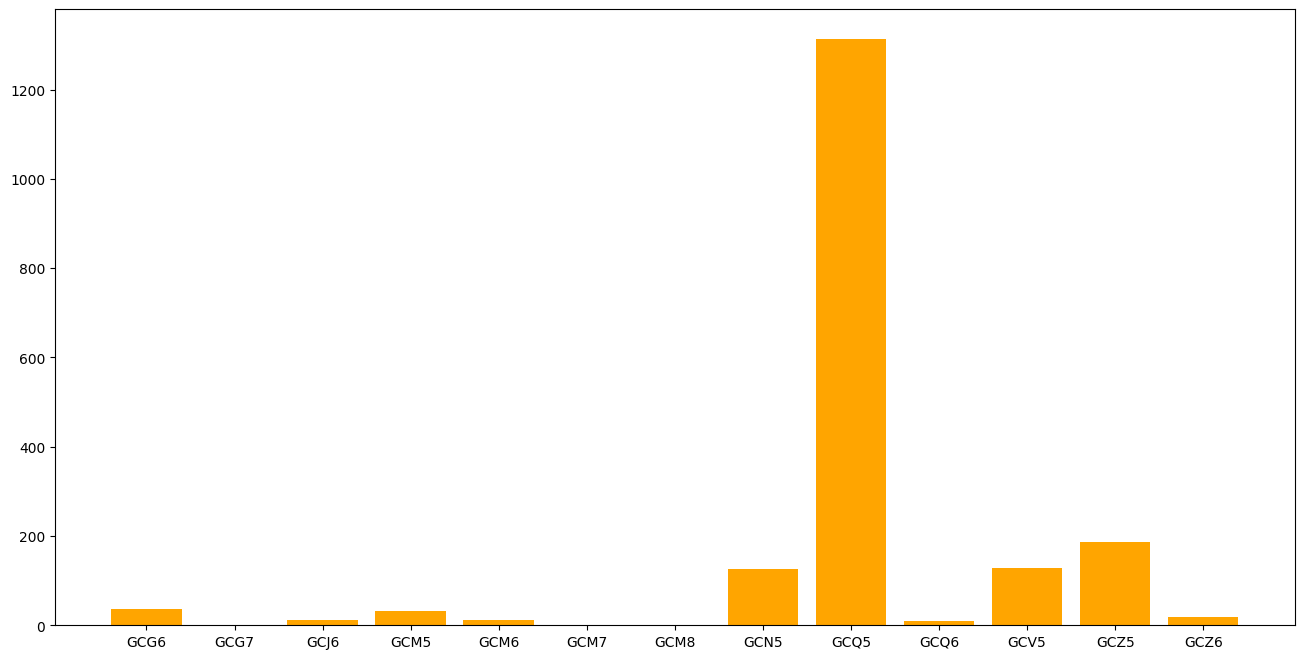

In [4]:
import matplotlib.pyplot as plt
import math
tickers = {}
for row in df.iterrows():
    for ticker in row[1].keys():
        if ticker not in tickers.keys(): tickers[ticker] = 0
        val = row[1][ticker]
        if not math.isnan(val): tickers[ticker] += 1

#print(tickers.items())
print(tickers.keys(),tickers.values())
plt.figure(figsize=(16,8))
plt.bar(list(tickers.keys()),list(tickers.values()),color='orange')

plt.show()


The most liquid contract appears to be GCQ5, which settles Q=August 5=2015, or 08/2015. Why is it not the july contract? Because August is an active month for gold futures, and July is not.

Great, so now let's just process our data to match a timestamp up with the last price of the most liquid contract.

One issue here is that the most liquid contract is not always traded at every timestamp. 

So let's just filter the rows where the most liquid timestamp is traded.


In [5]:
ticker_liquidity = sorted(tickers.items(), reverse=True, key=lambda x:x[1])

most_liquid_ticker = ticker_liquidity[0]
print(most_liquid_ticker)

most_liquid_ticker = most_liquid_ticker[0]

('GCQ5', 1314)


In [7]:
price_col = 'price_' + most_liquid_ticker
liquid_df = {'timestamp':[],price_col:[]}
for row in df.iterrows():
    if not math.isnan(row[1][most_liquid_ticker]):
        liquid_df['timestamp'].append(row[0])
        liquid_df[price_col].append(row[1][most_liquid_ticker])


print(liquid_df.keys())
futures_df = pd.DataFrame(liquid_df)

futures_df.head(-10)


dict_keys(['timestamp', 'price_GCQ5'])


,timestamp,price_GCQ5
0,2015-06-11 00:00:00+00:00,1185.7
1,2015-06-11 00:01:00+00:00,1185.7
2,2015-06-11 00:02:00+00:00,1185.6
3,2015-06-11 00:03:00+00:00,1185.5
4,2015-06-11 00:04:00+00:00,1185.5
...,...,...
1299,2015-06-11 23:32:00+00:00,1181.3
1300,2015-06-11 23:33:00+00:00,1181.3
1301,2015-06-11 23:35:00+00:00,1181.3
1302,2015-06-11 23:37:00+00:00,1181.3


NICE!!!!! now we have a much more clean dataframe.

## SPOT GOLD DATA

Okay, now let's get spot gold prices. I'm looking for data going back to 2015, which I think might be difficult to find.

- https://www.dukascopy.com/swiss/english/marketwatch/historical/ provides bullshit data
- alphavantage only provides the last day of historical data

- https://www.histdata.com/download-free-forex-historical-data/?/metatrader/1-minute-bar-quotes/XAUUSD worked but I had to manually download them and put them in one folder

In [1]:
def load_mt4_data(filepath):
    #don't treat first row as columns
    df = pd.read_csv(filepath, sep=',', header=None)

    df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

    #combine date and time into a datetime column
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], utc=True)
    df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

    return df

In [6]:
import pandas as pd
spot_path = '../../../data/spot_data/'

file_names = ['20'+str(yr) for yr in range(15,25)] + ['2025_' + str(m) for m in range(1,6)]
print(file_names)

df = pd.DataFrame()

for fn in file_names:
    file_name = spot_path + fn + '.csv'
    temp = load_mt4_data(file_name)
    df = pd.concat([df, temp])

df.to_csv('spot_gold_data.csv')

['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025_1', '2025_2', '2025_3', '2025_4', '2025_5']


That was annoying but I combined everything into one csv for spot data. Let's examine it.

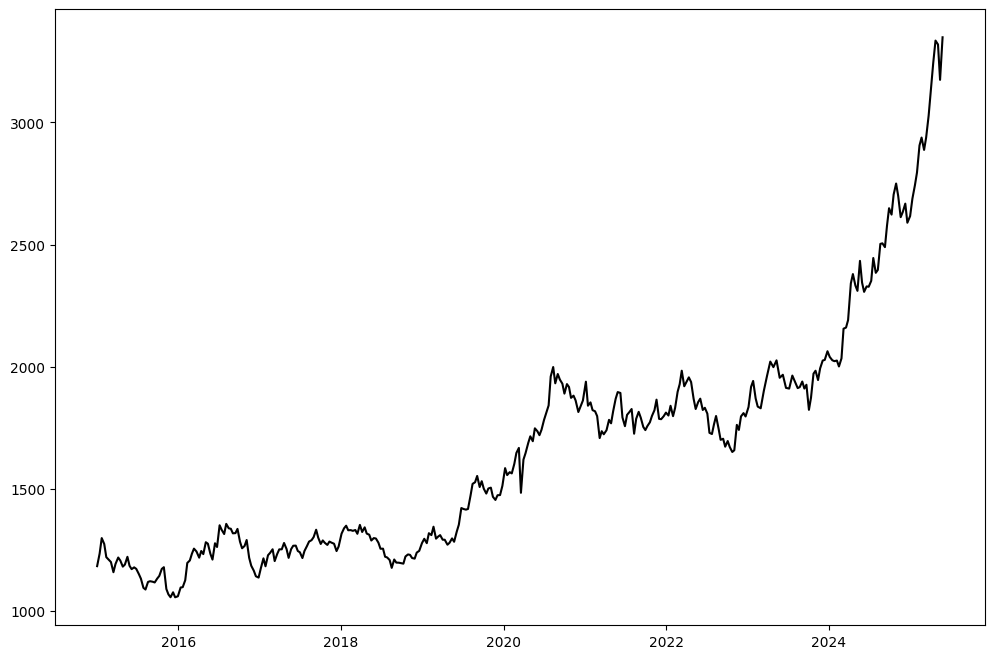

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#load csv
spot_df = pd.read_csv('spot_gold_data.csv')

#make sure sorted by datetime
spot_df['timestamp'] = pd.to_datetime(spot_df['Datetime'], utc=True)
spot_df.sort_values('timestamp', inplace=True)
spot_df.reset_index(drop=True, inplace=True)

#only care about closing prices
spot_df = spot_df[['timestamp','Close']]



#downsample so we can plot
n = 10000



plt.figure(figsize=(12,8))

x,y = spot_df['timestamp'].iloc[::n], spot_df['Close'].iloc[::n]

plt.plot(x,y, color='black')
plt.show()

In [21]:
filtered = spot_df[spot_df['timestamp'].dt.date == pd.to_datetime('2015-06-11').date()]
spot_df = filtered

In [18]:
futures_df = pd.read_csv('futures_long_format.csv')
futures_df['timestamp'] = pd.to_datetime(futures_df['timestamp'], utc=True)

This looks great! Now we can put XAU/USD and our futures together and examine how they change with respect to each other.

In [21]:
print(futures_df['timestamp'].dtype)
print(spot_df['timestamp'].dtype)

prices = pd.merge_asof(futures_df.sort_values('timestamp'),
                       spot_df.sort_values('timestamp'),
                       on='timestamp',
                       direction='backward')

prices = prices.rename(columns={
    'Close': 'spot_price',
    'price': 'future_price'
})

print(prices.head(-50))
prices.to_csv('merged_spot_futures.csv')



datetime64[ns, UTC]
datetime64[ns, UTC]
                        timestamp symbol  future_price  spot_price
0       2015-06-11 00:00:00+00:00   GCQ5        1185.7    1185.920
1       2015-06-11 00:01:00+00:00   GCQ5        1185.7    1186.020
2       2015-06-11 00:02:00+00:00   GCQ5        1185.6    1186.070
3       2015-06-11 00:03:00+00:00   GCQ5        1185.5    1185.940
4       2015-06-11 00:04:00+00:00   GCQ5        1185.5    1185.970
...                           ...    ...           ...         ...
3527299 2025-06-10 23:04:00+00:00   GCQ5        3344.2    3289.355
3527300 2025-06-10 23:05:00+00:00   GCQ5        3344.7    3289.355
3527301 2025-06-10 23:06:00+00:00   GCQ5        3346.1    3289.355
3527302 2025-06-10 23:07:00+00:00   GCQ5        3346.1    3289.355
3527303 2025-06-10 23:08:00+00:00   GCQ5        3345.2    3289.355

[3527304 rows x 4 columns]


calculate hedge ratio using OLS

In [23]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

X = prices['future_price']
Y = prices['spot_price']
X = sm.add_constant(X)  #add intercept term

model = sm.OLS(Y, X).fit()
hedge_ratio = model.params[1]  # slope coefficient
print(f"Hedge ratio: {hedge_ratio:.4f}")

Hedge ratio: 0.9897


/var/folders/lh/1dgly4594bn8mdjfz3vmlyr80000gn/T/ipykernel_81944/274239986.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]  # slope coefficient


calculate and plot spread

2635


/var/folders/lh/1dgly4594bn8mdjfz3vmlyr80000gn/T/ipykernel_81944/4259872936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['spread'] = filtered['spot_price'] - hedge_ratio * filtered['future_price']


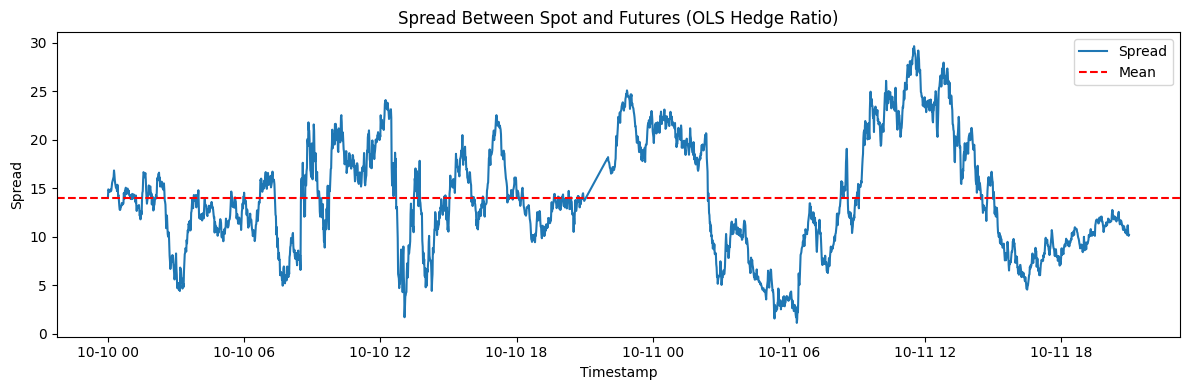

In [ ]:
start_date, end_date = pd.to_datetime('2024-10-10').date(), pd.to_datetime('2024-10-11').date()

filtered = prices.loc[(prices['timestamp'].dt.date >= start_date) & (prices['timestamp'].dt.date <= end_date)]


print(len(filtered))

filtered['spread'] = filtered['spot_price'] - hedge_ratio * filtered['future_price']

plt.figure(figsize=(12, 4))
plt.plot(filtered['timestamp'], filtered['spread'], label='Spread')
plt.axhline(filtered['spread'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Spread Between Spot and Futures (OLS Hedge Ratio)')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.legend()
plt.tight_layout()
plt.show()

1249


In [50]:
adf_result = adfuller(filtered['spread'].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: -3.7977045424210454
p-value: 0.002930888034552159
Critical Value 1%: -3.4328598727101833
Critical Value 5%: -2.862648868616968
Critical Value 10%: -2.5673602902877883


Using the raw spot price with the futures price doesn't seem to cut it, so let's try calculating some theos.

To do that, we need to get the cost of carry and thus the exact expiration date of each symbol given the symbol and the timestamp.


In [57]:
import pandas as pd
import calendar

def gold_futures_expiry(symbol, timestamp):
    """
    Given a CME gold futures symbol (e.g. 'GCQ5') and a timestamp,
    deduce the full expiry date based on CME rule:
    Gold futures expire on the third last business day of the delivery month.
    """
    import pandas as pd
    import calendar

    MONTH_CODES = {
        'F': 1, 'G': 2, 'H': 3, 'J': 4, 'K': 5, 'M': 6,
        'N': 7, 'Q': 8, 'U': 9, 'V': 10, 'X': 11, 'Z': 12
    }

    if len(symbol) != 4 or not symbol.startswith('GC'):
        raise ValueError("Invalid symbol format")

    month_code = symbol[2]
    year_digit = int(symbol[3])
    trade_year = pd.to_datetime(timestamp).year

    # Infer full year using trade_year context
    trade_decade = (trade_year // 10) * 10
    candidate_year = trade_decade + year_digit

    # Adjust if candidate year is too far from trade year
    if candidate_year < trade_year - 5:
        candidate_year += 10
    elif candidate_year > trade_year + 5:
        candidate_year -= 10

    delivery_month = MONTH_CODES[month_code]

    expiry_month = delivery_month
    expiry_year = candidate_year

    # Calculate third last business day of the delivery month
    bus_days = pd.date_range(start=f"{expiry_year}-{expiry_month:02d}-01",
                             end=f"{expiry_year}-{expiry_month:02d}-{calendar.monthrange(expiry_year, expiry_month)[1]}",
                             freq='B')
    expiry_date = bus_days[-3].date()
    return expiry_date



prices['expiry_date'] = prices.apply(lambda x: gold_futures_expiry(x['symbol'], x['timestamp']), axis=1)

prices.head(-10)

,timestamp,symbol,future_price,spot_price,spread,expiry_date
0,2015-06-11 00:00:00+00:00,GCQ5,1185.7,1185.920,12.445617,2015-08-27
1,2015-06-11 00:01:00+00:00,GCQ5,1185.7,1186.020,12.545617,2015-08-27
2,2015-06-11 00:02:00+00:00,GCQ5,1185.6,1186.070,12.694586,2015-08-27
3,2015-06-11 00:03:00+00:00,GCQ5,1185.5,1185.940,12.663555,2015-08-27
4,2015-06-11 00:04:00+00:00,GCQ5,1185.5,1185.970,12.693555,2015-08-27
...,...,...,...,...,...,...
3527339,2025-06-10 23:44:00+00:00,GCQ5,3345.6,3289.355,-21.748901,2025-08-27
3527340,2025-06-10 23:45:00+00:00,GCQ5,3345.7,3289.355,-21.847869,2025-08-27
3527341,2025-06-10 23:46:00+00:00,GCQ5,3344.8,3289.355,-20.957149,2025-08-27
3527342,2025-06-10 23:47:00+00:00,GCQ5,3345.4,3289.355,-21.550963,2025-08-27


In [58]:
prices.to_csv('merged_spot_futures_with_theo.csv')

In [2]:
import pandas as pd
import datetime
prices = pd.read_csv('data/merged_spot_futures_with_theo.csv')

that might work, we need to check the calendars to make sure

Let's factor in the risk free rate (1mo TBill) to calculate our theos. I got this from FRED. 
https://fred.stlouisfed.org/series/DGS1MO

In [3]:


df_rfr = pd.read_csv('data/risk_free_rates.csv')
df_rfr['observation_date'] = pd.to_datetime(df_rfr['observation_date'])

#convert from percent to decimal
df_rfr['rfr'] = df_rfr['DGS1MO'] / 100

#drop old column 
df_rfr = df_rfr.drop(columns=['DGS1MO'])

prices['timestamp'] = pd.to_datetime(prices['timestamp'], utc=True)
prices['date'] = prices['timestamp'].dt.date
prices['date'] = pd.to_datetime(prices['date'])

# --- 3. Merge on date ---
df_merged = pd.merge(prices, df_rfr, left_on='date', right_on='observation_date', how='left')

# --- 4. Clean up if desired ---
df_merged = df_merged.drop(columns=['observation_date'])

# --- 5. Result ---
print(df_merged.head())


   Unnamed: 0                 timestamp symbol  future_price  spot_price  \
0           0 2015-06-11 00:00:00+00:00   GCQ5        1185.7     1185.92   
1           1 2015-06-11 00:01:00+00:00   GCQ5        1185.7     1186.02   
2           2 2015-06-11 00:02:00+00:00   GCQ5        1185.6     1186.07   
3           3 2015-06-11 00:03:00+00:00   GCQ5        1185.5     1185.94   
4           4 2015-06-11 00:04:00+00:00   GCQ5        1185.5     1185.97   

      spread expiry_date       date     rfr  
0  12.445617  2015-08-27 2015-06-11  0.0001  
1  12.545617  2015-08-27 2015-06-11  0.0001  
2  12.694586  2015-08-27 2015-06-11  0.0001  
3  12.663555  2015-08-27 2015-06-11  0.0001  
4  12.693555  2015-08-27 2015-06-11  0.0001  


In [4]:
import numpy as np

def calculate_theo(spot_price, risk_free_rate, days_to_expiry):
    """
    Calculate theoretical futures price using cost of carry formula.
    Inputs:
      - spot_price: float
      - risk_free_rate: annualized decimal
      - days_to_expiry: float
    """
    T = days_to_expiry / 365
    return spot_price * np.exp(risk_free_rate * T)

df = df_merged

print(df)

# Ensure dates are datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['expiry_date'] = pd.to_datetime(df['expiry_date'])

# Calculate days to expiry
df['expiry_date'] = pd.to_datetime(df['expiry_date']).dt.tz_localize('UTC')
df['days_to_expiry'] = (df['expiry_date'] - df['timestamp']).dt.days

# Calculate theo per row using your rfr column
df['theo_price'] = df.apply(
    lambda x: calculate_theo(x['spot_price'], x['rfr'], x['days_to_expiry']),
    axis=1
)

# View results
print(df[['timestamp', 'symbol', 'spot_price', 'future_price', 'theo_price']].head())

         Unnamed: 0                 timestamp symbol  future_price  \
0                 0 2015-06-11 00:00:00+00:00   GCQ5        1185.7   
1                 1 2015-06-11 00:01:00+00:00   GCQ5        1185.7   
2                 2 2015-06-11 00:02:00+00:00   GCQ5        1185.6   
3                 3 2015-06-11 00:03:00+00:00   GCQ5        1185.5   
4                 4 2015-06-11 00:04:00+00:00   GCQ5        1185.5   
...             ...                       ...    ...           ...   
3527349     3527349 2025-06-10 23:54:00+00:00   GCQ5        3346.8   
3527350     3527350 2025-06-10 23:55:00+00:00   GCQ5        3346.6   
3527351     3527351 2025-06-10 23:56:00+00:00   GCQ5        3347.9   
3527352     3527352 2025-06-10 23:57:00+00:00   GCQ5        3348.0   
3527353     3527353 2025-06-10 23:58:00+00:00   GCQ5        3348.4   

         spot_price     spread expiry_date       date     rfr  
0          1185.920  12.445617  2015-08-27 2015-06-11  0.0001  
1          1186.020  12.545617 

In [5]:

prices = df


Let's recalculate the spread based on the actual theo now instead of the spot price

In [6]:


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

X = prices['future_price']
Y = prices['theo_price']
X = sm.add_constant(X)  #add intercept term

model = sm.OLS(Y, X).fit()
print(model.params)
hedge_ratio = model.params[1]  # slope coefficient
print(f"Hedge ratio: {hedge_ratio:.4f}")

const          NaN
future_price   NaN
dtype: float64
Hedge ratio: nan


/tmp/ipykernel_20811/3873982906.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]  # slope coefficient


Let's check the stationarity of the spread over the entire 10 year period first, to check if the spread is structurally stationary.

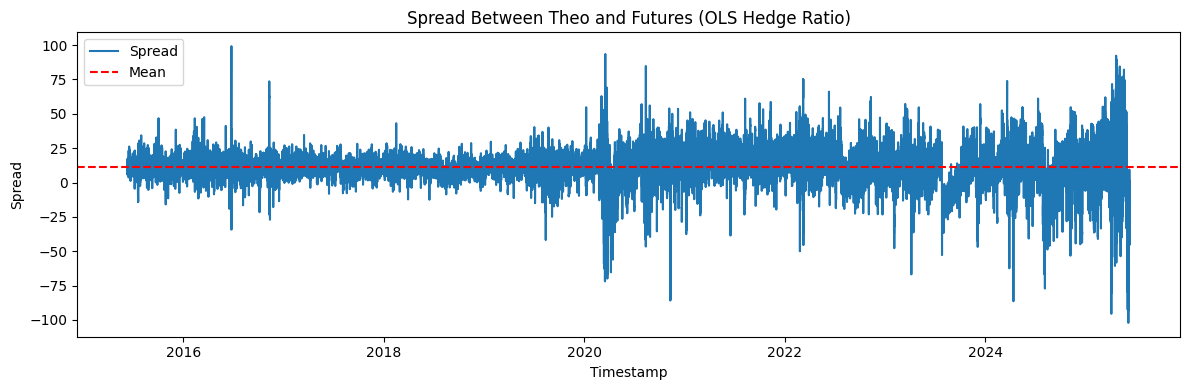

In [7]:
import matplotlib.pyplot as plt
#start_date, end_date = pd.to_datetime('2024-10-10').date(), pd.to_datetime('2024-10-11').date()

#filtered = prices.loc[(prices['timestamp'].dt.date >= start_date) & (prices['timestamp'].dt.date <= end_date)]


#print(len(filtered))

prices['future_theo_spread'] = prices['future_price'] - hedge_ratio * prices['theo_price']

plt.figure(figsize=(12, 4))
plt.plot(prices['timestamp'], prices['spread'], label='Spread')
plt.axhline(prices['spread'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Spread Between Theo and Futures (OLS Hedge Ratio)')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 7035/7035 [40:23<00:00,  2.90it/s]  


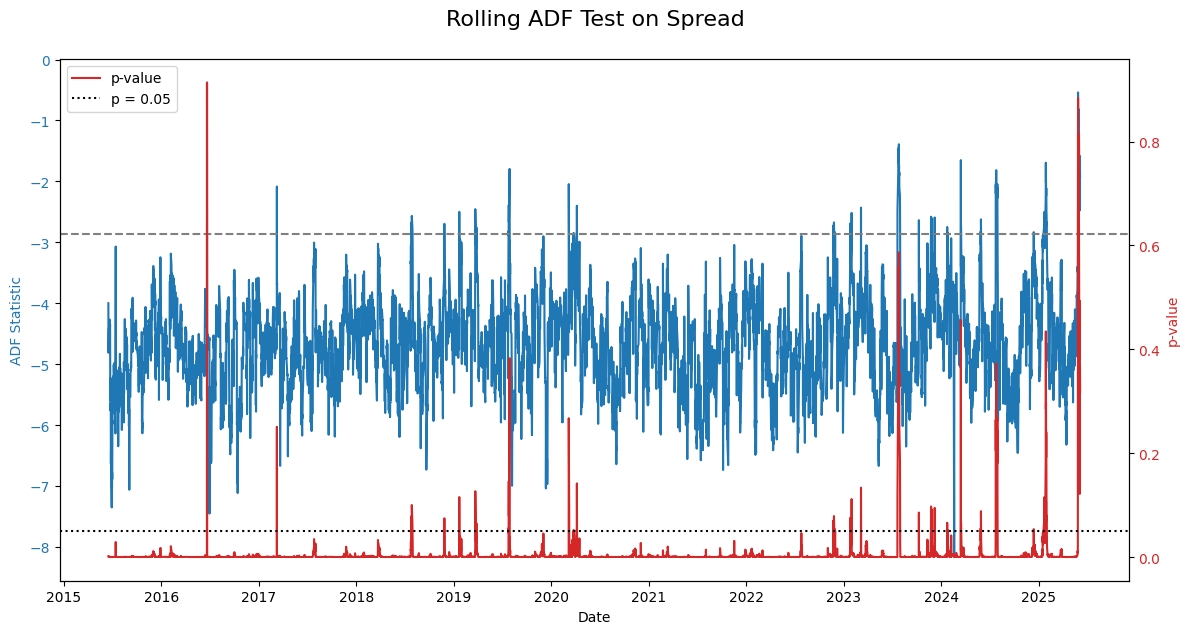

In [8]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Ensure your timestamp is datetime and sorted
prices['timestamp'] = pd.to_datetime(prices['timestamp'])
prices = prices.sort_values('timestamp')

# Parameters
window_size = 10000  # Adjust based on data granularity
step = 500  # How many rows to skip between tests

# Rolling ADF
rolling_adf_stats = []
rolling_pvals = []
rolling_dates = []

spread_series = prices['spread'].dropna().reset_index(drop=True)
timestamps = prices['timestamp'].reset_index(drop=True)

for i in tqdm(range(0, len(spread_series) - window_size, step)):
    window = spread_series[i:i+window_size]
    result = adfuller(window)
    rolling_adf_stats.append(result[0])
    rolling_pvals.append(result[1])
    rolling_dates.append(timestamps[i + window_size // 2])  # center of window

# Convert to DataFrame for easier plotting
rolling_df = pd.DataFrame({
    'Date': rolling_dates,
    'ADF Statistic': rolling_adf_stats,
    'p-value': rolling_pvals
})

# Plot ADF statistic and p-value
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('ADF Statistic', color=color)
ax1.plot(rolling_df['Date'], rolling_df['ADF Statistic'], label='ADF Statistic', color=color)
ax1.axhline(y=-2.86, color='gray', linestyle='--', label='5% Critical Value')  # typical threshold
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('p-value', color=color)
ax2.plot(rolling_df['Date'], rolling_df['p-value'], label='p-value', color=color)
ax2.axhline(y=0.05, color='black', linestyle=':', label='p = 0.05')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.suptitle("Rolling ADF Test on Spread", fontsize=16, y=1.05)
plt.legend(loc='upper left')
plt.show()

In [9]:
plt.savefig('adf_rolling.png')

<Figure size 640x480 with 0 Axes>